In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER




In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [10]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_hvac = t_all[:30, 1, :].reshape(30*14, 24)
train_fridge = t_all[:30, 2, :].reshape(30*14, 24)
train_mw = t_all[:30, 3, :].reshape(30*14, 24)





test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [13]:
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

n_clusters = (4, 3)
model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(test_agg)

SpectralBiclustering(init='k-means++', method='log', mini_batch=False,
           n_best=3, n_clusters=(4, 3), n_components=6, n_init=10,
           n_jobs=1, n_svd_vecs=None, random_state=0,
           svd_method='randomized')

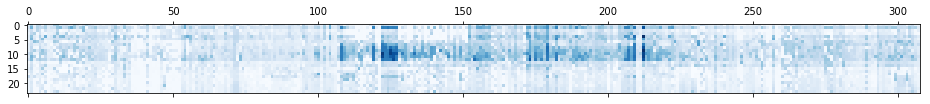

In [15]:
fit_data = test_agg[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data.T, cmap=plt.cm.Blues)


In [37]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

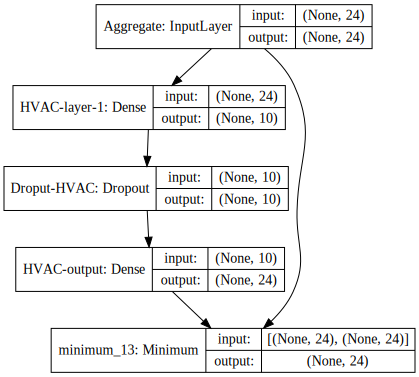

In [276]:
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum
from keras import regularizers
agg_input = keras.layers.Input(shape=[24],name='Aggregate')
hvac_dense_1 = keras.layers.Dense(units=10,name='HVAC-layer-1',activation='relu',activity_regularizer=regularizers.l1(10e-4))(agg_input)
dropout = keras.layers.Dropout(rate=0.3,name='Droput-HVAC')(hvac_dense_1)


out = keras.layers.Dense(units=24,name='HVAC-output',activation='relu')(dropout)
out = Minimum()([out, agg_input])


model = keras.Model(agg_input, out)


SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [277]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
HVAC-layer-1 (Dense)            (None, 10)           250         Aggregate[0][0]                  
__________________________________________________________________________________________________
Droput-HVAC (Dropout)           (None, 10)           0           HVAC-layer-1[0][0]               
__________________________________________________________________________________________________
HVAC-output (Dense)             (None, 24)           264         Droput-HVAC[0][0]                
__________________________________________________________________________________________________
minimum_13

In [278]:
model.compile('adam','mean_absolute_error')
model.fit(train_agg, train_mw, epochs=300, validation_split=0.2)

Train on 336 samples, validate on 84 samples
Epoch 1/300
336/336 [==============================] - 1s 3ms/step - loss: 280.5312 - val_loss: 229.9000
Epoch 2/300
336/336 [==============================] - 0s 61us/step - loss: 219.6083 - val_loss: 168.7873
Epoch 3/300
336/336 [==============================] - 0s 59us/step - loss: 153.8309 - val_loss: 119.5658
Epoch 4/300
336/336 [==============================] - 0s 57us/step - loss: 114.3648 - val_loss: 82.7144
Epoch 5/300
336/336 [==============================] - 0s 59us/step - loss: 77.7510 - val_loss: 57.2882
Epoch 6/300
336/336 [==============================] - 0s 61us/step - loss: 57.6610 - val_loss: 43.0129
Epoch 7/300
336/336 [==============================] - 0s 60us/step - loss: 42.6622 - val_loss: 34.4702
Epoch 8/300
336/336 [==============================] - 0s 58us/step - loss: 32.5801 - val_loss: 29.1666
Epoch 9/300
336/336 [==============================] - 0s 64us/step - loss: 25.6442 - val_loss: 25.7262
Epoch 10/300


Epoch 158/300
336/336 [==============================] - 0s 67us/step - loss: 6.3628 - val_loss: 8.5572
Epoch 159/300
336/336 [==============================] - 0s 68us/step - loss: 6.3612 - val_loss: 8.5572
Epoch 160/300
336/336 [==============================] - 0s 67us/step - loss: 6.3629 - val_loss: 8.5572
Epoch 161/300
336/336 [==============================] - 0s 61us/step - loss: 6.3628 - val_loss: 8.5572
Epoch 162/300
336/336 [==============================] - 0s 83us/step - loss: 6.3609 - val_loss: 8.5572
Epoch 163/300
336/336 [==============================] - 0s 95us/step - loss: 6.3597 - val_loss: 8.5572
Epoch 164/300
336/336 [==============================] - 0s 80us/step - loss: 6.3620 - val_loss: 8.5572
Epoch 165/300
336/336 [==============================] - 0s 70us/step - loss: 6.3599 - val_loss: 8.5572
Epoch 166/300
336/336 [==============================] - 0s 85us/step - loss: 6.3635 - val_loss: 8.5572
Epoch 167/300
336/336 [==============================] - 0s 80us

In [279]:
test_hvac[0, :]

array([  284.06668091,   260.91665649,   280.2166748 ,   287.58334351,
         378.4833374 ,  1008.7166748 ,    23.43333244,   429.66665649,
         460.81668091,   585.70001221,   349.2333374 ,   770.61663818,
         563.9666748 ,   694.04998779,  1034.51672363,  1055.44995117,
         657.29998779,  1054.2833252 ,   453.5       ,   492.45001221,
         521.66668701,   243.7666626 ,   235.9833374 ,     0.        ])

In [280]:
pred_hvac.shape

(308, 24)

In [281]:
pred_hvac = model.predict(test_agg)


from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_mw))
print(mean_absolute_error(pred_hvac, test_agg))




7.3498984593
1071.5096906


In [282]:
(pd.DataFrame(pred_hvac) - pd.DataFrame(test_agg)).max()

0     1.907349e-06
1    -3.877686e+00
2    -9.150000e+00
3     0.000000e+00
4     0.000000e+00
5    -9.633333e+00
6     0.000000e+00
7     2.861023e-06
8    -8.683333e+00
9     9.536743e-07
10    0.000000e+00
11    9.536743e-07
12   -9.583333e+00
13   -9.516666e+00
14   -4.711666e+01
15    3.099442e-06
16   -4.685000e+01
17    9.536743e-07
18   -7.310000e+01
19   -7.350000e+01
20   -4.180000e+01
21    0.000000e+00
22   -9.616667e+00
23   -9.533334e+00
dtype: float64

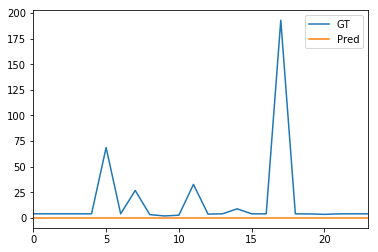

In [284]:
pd.Series(test_mw[1, :]).plot(label='GT')
#pd.Series(test_agg[1, :]).plot(label='GT')


pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred')




plt.legend()